# 2-D Bin Packing

The algorithm we'll be implementing is from [Bansal et al. (2014)](https://pdfs.semanticscholar.org/8e28/d9f9b90825660c57bab99a6ad7ec1d22d755.pdf). This algorithm is given in section 4 of the paper and yields a 1.5-approximation using rounding. I'll see if it's applicable to this set up.

## Algorithm

Input: set of items $i \in I$, where each item $i$ has two dimensions defined by $j$ and $k$ (compute and memory). 

1. Guess the optimum by trying all values between $1$ and $n$.
2. For each guessed value of Opt, do:

    a. Compute $\delta$ to classify values and pack medium VM's using Next Fit Decreasing Height (NFDH).
    
    b. Enumerate over all sizes that are rounded to and for each size the number of items that are rounded to that size, of the set of big, long, wide rectangles and the set of wide and long containers. **Map width to compute and height to memory.**
    
    c. For each guess, do Packing:
        - Assign big rectangles by solving flow network with the algorithm of Dinic.
        - Do greedy assignment of long and wide rectangles into $O(1)$ groups.
        - Pack $0(1)$ number of groups of long and wide rectangles into containers by brute force.
        - Pack the small rectangels using NFDH.
        - Pack $O(1)$ types of containers and $O(1)$ types of big rectangles using brute force.
        
3. Return a feasible packing.

In [12]:
import or_gym
import numpy as np
import matplotlib.pyplot as plt
import copy
from pyomo.environ import *
from pyomo.opt import SolverFactory
import time
%matplotlib inline
plt.style.use('cmu_paper')

In [24]:
env = or_gym.make('VMPacking-v0')

In [25]:
env.reset()

{'action_mask': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'avail_actions': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'state': array([[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
 

In [28]:
state = env.reset()['state']
s_bins = state[:-1]
s_item = state[-1]

In [37]:
# First fit: Pack item into lowest current bin where it fits, else into a new bin
def first_fit(state):
    s_bins, s_items = state[:-1], state[-1, 1:]
    action = None
    open_bins = np.where(s_bins[:,0]==1)[0]
    if len(open_bins) < 1:
        # Open first bin for item
        action = 0
    else:
        # Check each bin until one is found to fit the item
        for b in open_bins:
            if all(s_bins[b, [1, 2]] + s_items <= 1):
                action = b
        if action is None:
            action = np.max(open_bins) + 1
    return action

# Next fit: Pack item into current bin, else into a new bin
def next_fit(state):
    s_bins, s_items = state[:-1], state[-1, 1:]
    action = None
    current_bin = np.where(s_bins[:,0]==1)[0]
    if len(current_bin) < 1:
        # Open first bin
        action = 0
    else:
        # Check if it fits into current bin
        b = current_bin[-1]
        if all(s_bins[b, [1, 2]] + s_items <= 1):
            action = b
        else:
            action = b + 1
    return action    

In [38]:
state = env.reset()['state']
done = False
rewards, actions, items = [], [], []
while done == False:
    items.append(state[-1])
    action = first_fit(state)
    state_dict, reward, done, _ = env.step(action)
    state = state_dict['state'].copy()
    actions.append(action)
    rewards.append(reward)

In [40]:
# Average FF and NF
algos = ['FF']
algo_rewards = {}
N = 100
for a in algos:
    algo_rewards[a] = []
    for i in range(N):
        state = env.reset()['state']
        done = False
        rewards = []
        while done == False:
            if a == 'FF':
                action = first_fit(state)
#             elif a == 'NF':
#                 continue
#                 action = next_fit(state)
            state_dict, reward, done, _ = env.step(action)
            state = state_dict['state'].copy()
            rewards.append(reward)
        algo_rewards[a].append(sum(rewards))
    algo_rewards[a] = np.array(algo_rewards[a])

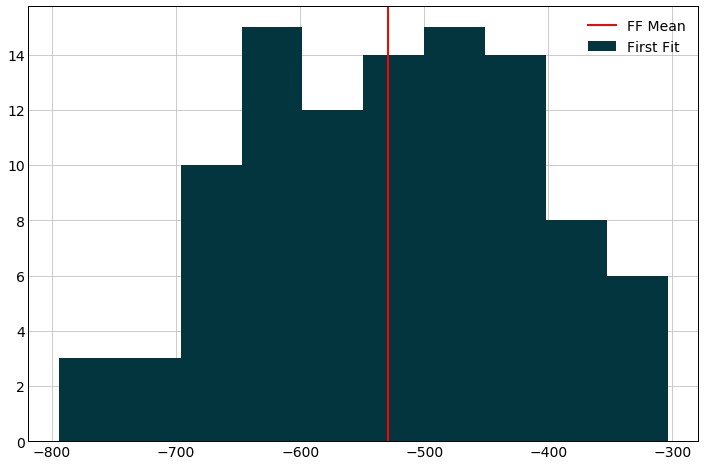

In [41]:
plt.figure(figsize=(12,8))
# plt.hist(algo_rewards['NF'], label='Next Fit')
# plt.axvline(algo_rewards['NF'].mean(), label='NF Mean')
plt.hist(algo_rewards['FF'], label='First Fit')
plt.axvline(algo_rewards['FF'].mean(), label='FF Mean', c='r')
plt.legend()
plt.show()

## MIP for VM Packing

In [3]:
env.step_limit = 5
env.n_pms = 10
env = or_gym.make('VMPacking-v0')
env.reset()

print(env.step_limit)

72


In [4]:
env.step_limit = 5
env.n_pms = 10
%timeit
env = or_gym.make('VMPacking-v0')
env.step_limit = 20
env.reset()
# env.demand = fixed_demand.copy()
m = ConcreteModel()

m.n = Set(initialize=[i for i in range(env.n_pms)]) # Num Physical Machines
m.v = Set(initialize=[i for i in range(env.step_limit)]) # Num Virtual Machines
m.t = Set(initialize=[i for i in range(env.step_limit)])
m.cpu_demand = Param(m.t,
    initialize={i: j[0] for i, j in enumerate(env.demand)})
m.mem_demand = Param(m.t,
    initialize={i: j[1] for i, j in enumerate(env.demand)})
m.durations = Param(m.v,
    initialize={i: env.step_limit - i for i in range(env.step_limit)})
min_demand = min(m.mem_demand[t] for t in m.t)
m.cpu_limit = env.cpu_capacity
m.mem_limit = env.mem_capacity

m.x = Var(m.n, m.v, m.t, within=Binary) # Assign VM's to machines
m.y = Var(m.n, m.v, within=Binary)
m.z = Var(m.n, m.t, within=Binary) # Number of Machine

@m.Constraint(m.n, m.t)
def cpu_constraint(m, n, t):
    return sum(m.x[n, v, t] * m.cpu_demand[v] 
               for v in m.v) - m.cpu_limit <= 0

@m.Constraint(m.n, m.t)
def mem_constraint(m, n, t):
    return sum(m.x[n, v, t] * m.mem_demand[v]
               for v in m.v) - m.mem_limit <= 0

@m.Constraint(m.n, m.v)
def duration_constraint(m, n, v):
    return sum(m.x[n, v, t] 
            for t in m.t)- m.y[n, v] * m.durations[v] == 0

@m.Constraint(m.v)
def vm_machine_assignment(m, v):
    return sum(m.y[n, v] for n in m.n) == 1

@m.Constraint(m.v, m.t)
def assignment_constraint(m, v, t):
    if t >= v:
        return sum(m.x[n, v, t] for n in m.n) <= 1
    else:
        return sum(m.x[n, v, t] for n in m.n) == 0
    
@m.Constraint(m.n, m.v, m.t)
def time_constraint(m, n, v, t):
    return (m.z[n, t] - m.x[n, v, t]) >= 0
    
# Maximize PM Packing
# m.obj = Objective(expr=(
#     sum(m.y[n, v] for v in m.v for n in m.n)),
#     sense=minimize)
# m.obj = Objective(expr=(
#     sum(m.x[n, v, t]
#         for n in m.n
#         for v in m.v
#         for t in m.t)),
#     sense=minimize)
m.obj = Objective(expr=(
    sum(sum(m.x[n, v, t] * (m.cpu_demand[v] + m.mem_demand[v])
        for v in m.v) - 2 * m.z[n, t]
        for n in m.n
        for t in m.t)),
    sense=maximize)

solver = SolverFactory('gurobi')
solver.options['MIPGap'] = 0.05
solver.options['Threads'] = 4
# solver.options
results = solver.solve(m, tee=True)

plan = []
for v in m.v:
    for t in m.t:
        if v == t:
            for n in m.n:
                if m.x[n, v, t].value is None:
                    continue
                if m.x[n, v, t].value > 0:
                    plan.append([n, v, t])

plan = np.vstack(plan)
print(plan)
rewards = []
actions = []
states = []
done = False
for a in plan:
    t = a[1]
    action = a[0]
    state, r, done, _ = env.step(action)
    states.append(copy.deepcopy(state))
    actions.append(action)
    rewards.append(r)
    if done:
        print(sum(rewards), len(rewards), t)
        break
        
print(m.obj.expr())

AttributeError: 'VMPackingEnv' object has no attribute 'cpu_capacity'

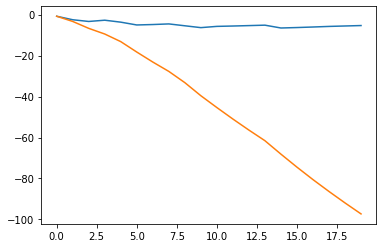

In [8]:
plt.plot(rewards)
plt.plot(np.cumsum(rewards))

In [5]:
def test_env(env, n_episodes, print_output=True):
    rewards, eps, eps_total = [], [], []
    training = True
    batch = 0
    t_start = time.time()
    while training:
        t_batch = time.time()
        results = trainer.train()
        rewards.append(results['episode_reward_mean'])
        eps.append(results['episodes_this_iter'])
        eps_total.append(results['episodes_total'])
        batch += 1
        t_end = time.time()
        if sum(eps) >= n_episodes:
            training = False
            break
        if batch % 10 == 0 and print_output:
            t = t_end - t_batch
            t_tot = t_end - t_start
            print("\rEpisode: {}\tMean Rewards: {:.1f}\tEpisodes/sec: {:.2f}\tTotal Time: {:.1f}s".format(
                eps_total[-1], rewards[-1], eps[-1]/t, t_tot), end="")
            
    print("\nTotal Training Time: {:.1f}s\t".format(t_end - t_start))
    return trainer, results

In [6]:
from or_gym.algos.rl_utils import *
import ray
from ray.rllib.agents import ppo
import time

In [7]:
env_name = 'VMPacking-v0'
n_episodes = 20000
print_output = True
ray.init(ignore_reinit_error=True)
trainer = ppo.PPOTrainer(env=create_env(env_name),
    config={
    "env_config": {
        "reuse_actors":True},
    "vf_clip_param": 10000, # Set to high number to avoid any warnings
    "model": {
        "fcnet_activation": "elu",
        "fcnet_hiddens": [128, 128, 128]}
    })
env = gym.make(env_name)
print('Testing {}'.format(env_name))
trainer, results = test_env(env, n_episodes, print_output)

2020-04-13 17:48:32,484	ERROR worker.py:679 -- Calling ray.init() again after it has already been called.
2020-04-13 17:48:35,996	WARNING util.py:45 -- Install gputil for GPU system monitoring.


Testing VMPacking-v0
Episode: 19384	Mean Rewards: -401.3	Episodes/sec: 31.76s	Total Time: 585.2sTotal Training Time: 604.1s	


In [8]:
results

{'episode_reward_max': -207.9849976284188,
 'episode_reward_min': -1281.3886322041612,
 'episode_reward_mean': -485.21976611436634,
 'episode_len_mean': 18.830985915492956,
 'episodes_this_iter': 213,
 'policy_reward_min': {},
 'policy_reward_max': {},
 'policy_reward_mean': {},
 'custom_metrics': {},
 'sampler_perf': {'mean_env_wait_ms': 0.11419706916459613,
  'mean_processing_ms': 0.20324339069410527,
  'mean_inference_ms': 0.7420270892431968},
 'off_policy_estimator': {},
 'info': {'num_steps_trained': 369024,
  'num_steps_sampled': 372000,
  'sample_time_ms': 2165.83,
  'load_time_ms': 6.247,
  'grad_time_ms': 4216.799,
  'update_time_ms': 7.276,
  'learner': {'default_policy': {'cur_kl_coeff': 1.0125000476837158,
    'cur_lr': 4.999999873689376e-05,
    'total_loss': 61899.156,
    'policy_loss': -0.12169668,
    'vf_loss': 61899.258,
    'vf_explained_var': 0.37244275,
    'kl': 0.018940274,
    'entropy': 3.2505357,
    'entropy_coeff': 0.0}}},
 'timesteps_this_iter': 4000,
 'do

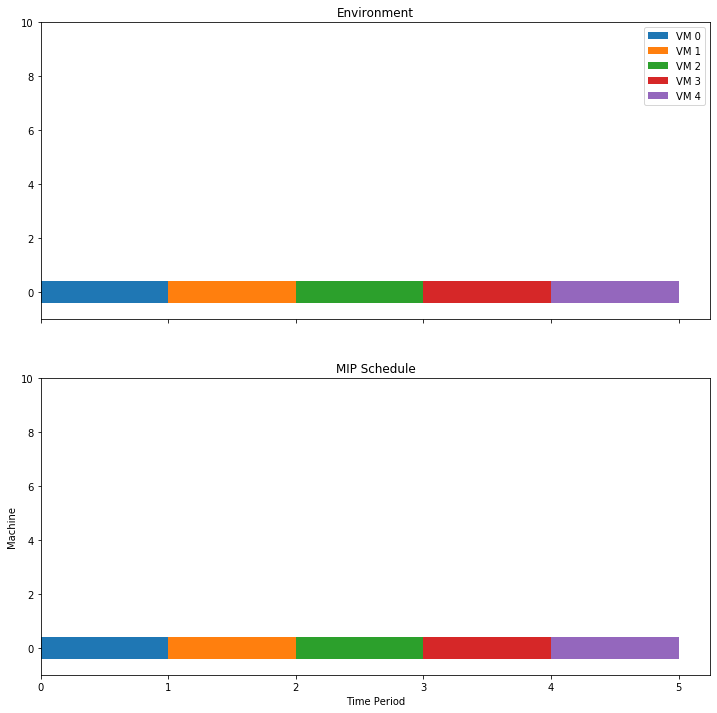

In [52]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,12))
for idx in m.x:
    if m.x[idx].value > 0:
        start = idx[-1]
        ax[1].barh(idx[0], 1, left=start, color=colors[idx[1]])
        
ax[1].set_ylabel('Machine')
ax[1].set_xlabel('Time Period')
ax[1].set_title('MIP Schedule')
ax[1].set_ylim([-1, 10])

for i, a in enumerate(actions):
    ax[0].barh(a, env.step_limit - i, left=i, color=colors[i], label='VM {}'.format(i))
    
ax[0].set_title('Environment')
ax[0].legend()
ax[0].set_ylim([-1, 10])
plt.show()

In [398]:
env.state[0][:, 0].sum()

4.0

In [36]:
assignments = np.array([i for i in m.x if m.x[i].value > 0])
for i in range(env.step_limit):
    machines = assignments[np.where(assignments[:, 2]==i)[0], 0]
    print(machines)
    print("Order {} appears {} times".format(i, len(np.where(assignments[:, 1]==i)[0])))

[1]
Order 0 appears 5 times
[0 1]
Order 1 appears 4 times
[0 1 1]
Order 2 appears 3 times
[0 1 1 1]
Order 3 appears 2 times
[0 1 1 1 1]
Order 4 appears 1 times


In [37]:
assignments[np.where(assignments[:, 1]==assignments[:, 2])[0]]

array([[0, 1, 1],
       [1, 0, 0],
       [1, 2, 2],
       [1, 3, 3],
       [1, 4, 4]])

In [38]:
# Calc rewards from env states
_rewards = []
for s in states:
    pm_state = s[0].copy()
    _r = np.sum(pm_state[:, 0] * (pm_state[:, 1] - 1 + pm_state[:, 2] - 1))
    _rewards.append(_r)
    
print(sum(rewards) == sum(_rewards))
sum(_rewards)

True


-13.314997412319817

In [39]:
sum(pm_state[:, 0] * (pm_state[:, 1:].sum(axis=1) - 2))

-2.354107317715701

In [40]:
pm_state[:, 1] + pm_state[:, 2]

array([0.24194459, 1.40394809, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [41]:
rewards

[-1.7178341169347118,
 -3.4758895265631686,
 -3.206147101794529,
 -2.561019349311707,
 -2.3541073177157013]

In [42]:
_rewards

[-1.7178341169347118,
 -3.4758895265631686,
 -3.206147101794529,
 -2.561019349311707,
 -2.3541073177157013]

In [45]:
t = 2
rew = np.array([sum(m.x[n, v, t].value * (m.cpu_demand[v] + m.mem_demand[v])
                for v in m.v) - 2
                for n in m.n])
rew

array([-1.75805541, -1.44809169, -2.        , -2.        , -2.        ,
       -2.        , -2.        , -2.        , -2.        , -2.        ])

In [375]:
for n in m.n:
    for v in m.v:
        if m.x[n, v, t].value > 0:
            val = m.x[n, v, t].value * (m.cpu_demand[v] + m.mem_demand[v] - 2)
            print(val, n, v, t)

-0.9515527922119307 2 1 2
-1.8136776514843778 5 2 2
-1.7295896982947734 8 0 2


In [376]:
o_rews = []
for t in m.t:
    for n in m.n:
        o_rew = sum(m.x[n, v, t].value * (m.cpu_demand[v] + m.mem_demand[v])
                    for v in m.v) - sum(2 * m.y[n, v].value for v in m.v)
        o_rews.append(o_rew)

opt_rewards = sum(o_rews)

print(sum(rewards) == opt_rewards)
opt_rewards

False


-43.06453278147045

In [345]:
opt_rewards

-25.028200824223646

In [377]:
rew = np.array(sum([sum(m.x[n, v, t].value * (m.cpu_demand[v] - 1 + m.mem_demand[v] - 1) 
                for v in m.v 
                for n in m.n) 
                for t in m.t]))
rew[rew!=0].sum()

-23.06453278147045

In [324]:
x_n = np.array([m.x[n, v, t].value for v in m.v for n in m.n for t in m.t]).reshape(max(m.n)+1, -1)

# Online Optimization

In [3]:
for i in range(env.step_limit):
    action = env.action_space.sample()
    s, r, done, _ = env.step(action)
    if done:
        break

In [58]:
env.n_pms = 10
_ = env.reset()

In [8]:
def build_online_vm_opt(env):
#     print("Solving from t={}".format(env.step_count))
    m = ConcreteModel()
    
    t0 = env.current_step
    m.n = Set(initialize=[i for i in range(env.n_pms)]) # Num Physical Machines
    # One new VM at each time step
    m.v = Set(initialize=[v for v in range(t0+1)])
    m.t = Set(initialize=[t for t in range(env.step_limit)])
    
    m.cpu_demand = Param(m.v,
        initialize={i: j[1] for i, j in enumerate(env.demand[:t0+1])})
    m.mem_demand = Param(m.v,
        initialize={i: j[2] for i, j in enumerate(env.demand[:t0+1])})
    m.durations = Param(m.v,
        initialize={v: env.step_limit - v for v in m.v})
    m.cpu_limit = env.cpu_capacity
    m.mem_limit = env.mem_capacity

    m.x = Var(m.n, m.v, m.t, within=Binary) # Assign VM's to machines
    m.y = Var(m.n, m.v, within=Binary)
    m.z = Var(m.n, m.t, within=Binary) # Number of Machine
    
    # Fix variables for pre-existing values
    if t0 > 0:
        for k in env.assignment:
            n = env.assignment[k]
            for t in m.t:
                if t >= k:
                    m.x[n, k, t].fix(1)
                else:
                    m.x[n, k, t].fix(0)
            m.y[n, k].fix(1)
        
    @m.Constraint(m.n, m.t)
    def cpu_constraint(m, n, t):
        return sum(m.x[n, v, t] * m.cpu_demand[v] 
                   for v in m.v) - m.cpu_limit <= 0

    @m.Constraint(m.n, m.t)
    def mem_constraint(m, n, t):
        return sum(m.x[n, v, t] * m.mem_demand[v]
                   for v in m.v) - m.mem_limit <= 0

    @m.Constraint(m.n, m.v)
    def duration_constraint(m, n, v):
        return sum(m.x[n, v, t] 
                for t in m.t)- m.y[n, v] * m.durations[v] == 0

    @m.Constraint(m.v)
    def vm_machine_assignment(m, v):
        return sum(m.y[n, v] for n in m.n) == 1

    @m.Constraint(m.v, m.t)
    def assignment_constraint(m, v, t):
        if t >= v:
            return sum(m.x[n, v, t] for n in m.n) <= 1
        else:
            return sum(m.x[n, v, t] for n in m.n) == 0

    @m.Constraint(m.n, m.v, m.t)
    def time_constraint(m, n, v, t):
        return (m.z[n, t] - m.x[n, v, t]) >= 0

    # Maximize PM Packing
    m.obj = Objective(expr=(
        sum(sum(m.x[n, v, t] * (m.cpu_demand[v] + m.mem_demand[v])
            for v in m.v) - 2 * m.z[n, t]
            for n in m.n
            for t in m.t)),
        sense=maximize)
    return m

In [108]:
print("Solving from t={}".format(env.step_count))
m = ConcreteModel()

t0 = env.step_count # Current time
m.n = Set(initialize=[i for i in range(env.n_pms)]) # Num Physical Machines
# One new VM at each time step
m.v = Set(initialize=[v for v in range(env.step_count+1)])
m.t = Set(initialize=[t for t in range(env.step_limit)])

m.cpu_demand = Param(m.v,
    initialize={i: j[0] for i, j in enumerate(env.demand[:t0+1])})
m.mem_demand = Param(m.v,
    initialize={i: j[1] for i, j in enumerate(env.demand[:t0+1])})
m.durations = Param(m.v,
    initialize={v: env.step_limit - v for v in m.v})
m.cpu_limit = env.cpu_capacity
m.mem_limit = env.mem_capacity

m.x = Var(m.n, m.v, m.t, within=Binary) # Assign VM's to machines
m.y = Var(m.n, m.v, within=Binary)
m.z = Var(m.n, m.t, within=Binary) # Number of Machine

# Fix variables for pre-existing values
if env.step_count > 0:
    for k in env.assignments:
        n = env.assignments[k]
        for t in m.t:
            if t >= k:
#                 print('Fixing x({},{},{})=1'.format(n, k, t))
                m.x[n, k, t].fix(1)
                m.z[n, t].fix(1)
            else:
                m.x[n, k, t].fix(0)
                m.z[n, t].fix(0)
        m.y[n, k].fix(1)

Solving from t=1


In [111]:
m = build_online_vm_opt(env)
solver = SolverFactory('gurobi')
results = solver.solve(m, tee=True)

Solving from t=1
Read LP format model from file /tmp/tmpouo8k3ng.pyomo.lp
Reading time = 0.00 seconds
x621: 863 rows, 580 columns, 2299 nonzeros
Optimize a model with 863 rows, 580 columns and 2299 nonzeros
Variable types: 1 continuous, 579 integer (579 binary)
Coefficient statistics:
  Matrix range     [3e-02, 2e+01]
  Objective range  [2e-01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Presolve removed 863 rows and 580 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: -32.0199 

Optimal solution found (tolerance 1.00e-04)
Best objective -3.201990200226e+01, best bound -3.201990200226e+01, gap 0.0000%


In [4]:
# Get plan
def extract_vm_packing_plan(model):
    plan = []
    for v in m.v:
        for t in m.t:
            if v == t:
                for n in m.n:
                    if m.x[n, v, t].value is None:
                        continue
                    if m.x[n, v, t].value > 0:
                        plan.append(n)

    return np.vstack(plan)

In [9]:
env = or_gym.make('VMPacking-v0')
env.n_pms = 10
env.step_limit = 5
solver = SolverFactory('gurobi')
env.reset()
# print(env.n_pms)
# print(env.step_limit)
done = False
actions = []
rewards = []
times, obj_vals, bin_vars = [], [], []
count = 0
t0 = time.time()
while done==False:
    t1 = time.time()
    m = build_online_vm_opt(env)
    results = solver.solve(m)
    # Get action plan
    plan = extract_vm_packing_plan(m)
    action = plan[-1].take(0)
    s, r, done, _ = env.step(action)
    actions.append(action)
    rewards.append(r)
    t2 = time.time()
    count += 1
    times.append(t2-t1)
    obj_vals.append(m.obj.expr())
    bin_vars.append(results['Problem'][0]['Number of binary variables'])
    if count % 10 == 0:
        print("Ep: {}\tSteps/s: {:.2f}\tTotal time (s): {:.2f}\tProjected Reward: {:.2f}".format(
            count, 10/np.mean(times[-10:]), t2-t0, obj_vals[-1]))

In [10]:
obj_vals

[-6.879288565766833,
 -5.740341785679621,
 -8.604289504615744,
 -11.336066707521216,
 -11.05476074496983]

In [11]:
rewards

[-1.3758577131533667,
 -1.0911210181315636,
 -2.0457702577769377,
 -3.411658859229675,
 -3.1303528966782883]

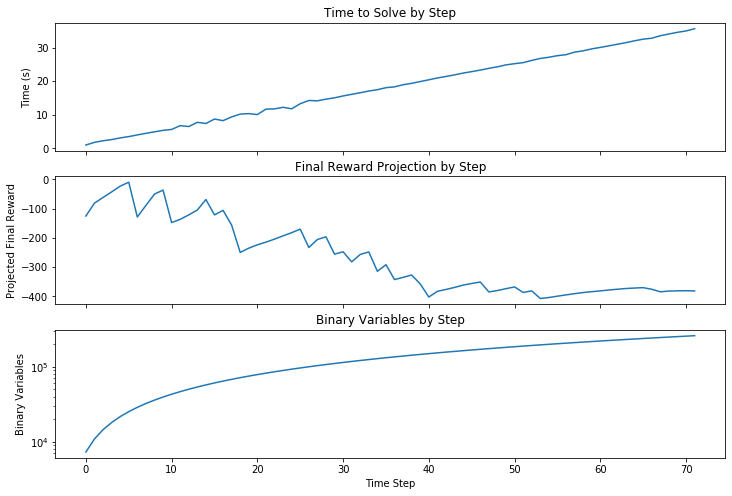

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(12,8), sharex=True)
ax[0].plot(times)
ax[0].set_title('Time to Solve by Step')
ax[0].set_ylabel('Time (s)')

ax[1].plot(obj_vals)
ax[1].set_title('Final Reward Projection by Step')
ax[1].set_ylabel('Projected Final Reward')

ax[2].plot(bin_vars)
ax[2].set_title('Binary Variables by Step')
ax[2].set_ylabel('Binary Variables')
ax[2].semilogy()
ax[2].set_xlabel('Time Step')
plt.show()

In [23]:
print(sum(times)/60*100/60)

36.487353490458595


In [4]:
x = np.array([[0.1, 0.4],
             [0.8, 0.9],
             [1, 0.3]])

y = np.array([0.1, 0.2])

In [21]:
z = (x + y) < 1
(z.sum(axis=1)!=2).astype(int)

array([0, 1, 1])

In [17]:
z

array([[ True,  True],
       [ True, False],
       [False,  True]])